## RAG Evaluation Notebook
by Andy Garcia


For this notebook, we will use a sample HR Manual from this source:<br>
https://www.icpau.co.ug/sites/default/files/Resources/SAMPLE%20HR%20MANUAL.pdf<br>
It's already downloaded in the ./data directory.

### 1. RAG
Let's start by learning how to use Retrieval Augmented Generation (RAG). There are two ways we can go about this: via the LLM's native API or via an LLM agnostic framework. We will explore using OpenAI's native API and the Langchain framework. For both cases we will use OpenAI as the LLM for generation, so you will need a working OpenAI API key. Set the environment variable using the cell below. Reminder: DO NOT upload your API KEY to Git!!!

In [ ]:
%env OPENAI_API_KEY=<YOUR API KEY HERE>

In [1]:
import os

In [ ]:

# Check if OPENAI_API_KEY is visible to the notebook
OPENAI_API_KEY = os.environ['OPENAI_API_KEY']
print(f'API KEY={OPENAI_API_KEY}')

In [2]:
data_folder = './data'
index_folder = './index'
document_folder = './document'

### 1.1. OpenAI API

In [78]:
# !pip install openai

In [3]:
from openai import OpenAI

client = OpenAI()
vector_store = client.beta.vector_stores.create(name="Employee Handbook",
                                                expires_after={
                                                    "anchor": "last_active_at",
                                                    "days": 1
                                                })

file_paths = [document_folder+'/SAMPLE HR MANUAL.pdf']
file_streams = [open(path, "rb") for path in file_paths]

file_batch = client.beta.vector_stores.file_batches.upload_and_poll(
    vector_store_id=vector_store.id, files=file_streams
)

print(file_batch.status)
print(file_batch.file_counts)

completed
FileCounts(cancelled=0, completed=1, failed=0, in_progress=0, total=1)


In [4]:
# Check the vector stores uploaded
vector_stores = client.beta.vector_stores.list()
for store in vector_stores:
    print(store)

VectorStore(id='vs_px30MKzWeRae7ih6Vy1lAVjS', created_at=1737428338, file_counts=FileCounts(cancelled=0, completed=0, failed=0, in_progress=0, total=0), last_active_at=1737428344, metadata={}, name=None, object='vector_store', status='completed', usage_bytes=0, expires_after=ExpiresAfter(anchor='last_active_at', days=7), expires_at=1738033144)
VectorStore(id='vs_vfjaqMmkGouzAkEBuRawdde7', created_at=1737428336, file_counts=FileCounts(cancelled=0, completed=1, failed=0, in_progress=0, total=1), last_active_at=1737428342, metadata={}, name='Employee Handbook', object='vector_store', status='completed', usage_bytes=29110, expires_after=ExpiresAfter(anchor='last_active_at', days=1), expires_at=1737514742)
VectorStore(id='vs_ecLh6F0BTUtdoKaz9tUfTJq2', created_at=1737428228, file_counts=FileCounts(cancelled=0, completed=0, failed=0, in_progress=0, total=0), last_active_at=1737428235, metadata={}, name=None, object='vector_store', status='completed', usage_bytes=0, expires_after=ExpiresAfter(

In [5]:
vector_store = vector_stores.data[0]

Ok, technically we are using an agent, but the agent uses RAG under the hood!

In [6]:
# Create an assistant

instructions = "You are an HR Assistant. If you don't have the answer from the document, refer them to directly contact HR"

assistant = client.beta.assistants.create(
    name="HR Employee Chatbot",
    instructions=instructions,
    tools=[{"type": "file_search"}],
    model="gpt-4o",
)

In [7]:
# add the vector store to the assistant

assistant = client.beta.assistants.update(
    assistant_id=assistant.id,
    tool_resources={'file_search': {'vector_store_ids': [vector_store.id]}}
)

In [8]:

# Create a thread
thread = client.beta.threads.create()


def add_message(message: str, thread=thread):
    message = client.beta.threads.messages.create(
        thread_id=thread.id,
        role="user",
        content=message
    )

    return message


def message_agent(message: str, instructions: str = None):
    user_messages = add_message(message)
    run = client.beta.threads.runs.create_and_poll(
        thread_id=thread.id,
        assistant_id=assistant.id,
        instructions=instructions
    )

    messages = client.beta.threads.messages.list(
        thread_id=thread.id
    )
    return messages

In [9]:
message = "Give a short summary of the document"
messages = message_agent(message=message)
print(messages.data[0].content[0].text.value)

I couldn't find a summarized version directly from the document. Please provide more specific information you need from the document, or you can contact HR directly for assistance.


### 1.2. Langchain / LLAMA Index

Uncomment the next cell to install the required modules 

In [37]:
# ! pip install llama_index langchain langchain-openai

In [4]:
from llama_index.core import GPTVectorStoreIndex,  SimpleDirectoryReader

# from llama_index.legacy.readers.file.base import SimpleDirectoryReader

from langchain_openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core.node_parser import SentenceSplitter
from llama_index.llms.openai import OpenAI
from llama_index.core import Settings
from llama_index.core import StorageContext, load_index_from_storage

In [11]:
def construct_baseline_index(document_folder, index_folder):
    index_folder = index_folder+'/baseline'
    print(index_folder)
    if not os.path.exists(index_folder):
        print('CREATING')
        os.makedirs(index_folder)
    Settings.tokenizer = None
    Settings.llm = OpenAI(model="gpt-4")
    Settings.embed_model = OpenAIEmbedding(model="text-embedding-3-small")
    print('INDEXING')
    documents = SimpleDirectoryReader(document_folder).load_data()
    index = GPTVectorStoreIndex.from_documents(documents)
    print('SAVING INDEX TO DISK')
    index.storage_context.persist(index_folder)
    return index

In [14]:
# create the index
construct_baseline_index(document_folder, index_folder)

./index/baseline
INDEXING
SAVING INDEX TO DISK


In [5]:
query = 'Give a short summary of the document'
llm_ver = 'gpt-4'
storage_context = StorageContext.from_defaults(
    persist_dir=index_folder+'/baseline')
index = load_index_from_storage(storage_context)
llm = OpenAI(temperature=0, model_name=llm_ver)
resp = index.as_query_engine(llm=llm).query(query).response
print(resp)

The document is a Sample Human Resource Manual that covers various aspects of human resource management such as management of performance appraisal recommendations, compensation packages including salary payments and deductions, overtime allowance, facilitation like transport provision, and discipline guidelines. It also includes information on staff career development, performance evaluation procedures, performance reviews, and the annual performance review cycle. The manual emphasizes the importance of staff performance improvement, appropriate compensation based on performance, and maintaining discipline and integrity in conducting the firm's business.


### 2. LLM Evaluation
There are several ways to evaluate the performance of RAG. But first, we will need labeled data. The file hr_manual_dataset.csv contains queries to the HR Manual, an ground truth indication of whether or not the requested information is available in the manual, and a reference answer from ChatGPT 4o. Let's load the data:

In [58]:
# !pip install pandas

In [6]:
import pandas as pd

filename = data_folder + '/hr_manual_dataset.csv'
df = pd.read_csv(filename, header=None, names=['query', 'label', 'reference'])
df.head()

,query,label,reference
0,What is the purpose of the HR manual at ABC & ...,True,The purpose of the HR manual at ABC & Associat...
1,How does ABC & Associates handle recruitment a...,True,ABC & Associates handles recruitment and selec...
2,What are the probationary terms for new employ...,True,"At ABC & Associates, the probationary terms fo..."
3,How does the firm conduct performance evaluati...,True,ABC & Associates conducts performance evaluati...
4,What types of leave are available to employees...,True,"At ABC & Associates, employees have access to ..."


In [7]:
X = df['query']
y = df['label']
ref_answers = df['reference']

In [18]:
X.head()

0    What is the purpose of the HR manual at ABC & ...
1    How does ABC & Associates handle recruitment a...
2    What are the probationary terms for new employ...
3    How does the firm conduct performance evaluati...
4    What types of leave are available to employees...
Name: query, dtype: object

In [19]:
y.head()

0    True
1    True
2    True
3    True
4    True
Name: label, dtype: bool

In [20]:
ref_answers.head()

0    The purpose of the HR manual at ABC & Associat...
1    ABC & Associates handles recruitment and selec...
2    At ABC & Associates, the probationary terms fo...
3    ABC & Associates conducts performance evaluati...
4    At ABC & Associates, employees have access to ...
Name: reference, dtype: object

### 3. LLM Evaluaion via Confusion Matrix
Now we explore using the well-known Machine Learning method. Let's load the dataset:

In [57]:
# !pip install scikit-learn

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score, f1_score

### 3.1 Langchain / LLAMA Index

In [105]:
y_predict = []

for query in X:
    prompt = f'Use only the information provided in the document. \
              respond only with "True" if you find the answer to \
              the query and only with "False" if not. The query is: {query}'
    
    resp = index.as_query_engine(llm=llm).query(prompt).response
    print(resp)
    y_predict.append(resp)

y_predict = [s == "True" for s in y_predict]

True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False


In [164]:
precision = precision_score(y, y_predict)
recall = recall_score(y, y_predict)
accuracy = accuracy_score(y, y_predict)
f1 = f1_score(y, y_predict)
cm = confusion_matrix(y, y_predict)
result = (f'Performance Evaluation for Langchain / LLAMA Index:\n\
precision : {precision}\nrecall : {recall}\n\
accuracy : {accuracy}\nf1 score : {f1}')
print(result)

Performance Evaluation for Langchain / LLAMA Index:
precision : 1.0
recall : 1.0
accuracy : 1.0
f1 score : 1.0


### 2.2: LLAMA Index CorrectnesEvaluator

In [18]:
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=[False, True])
cm_display.plot()

NameError: name 'ConfusionMatrixDisplay' is not defined

### 3.2 OpenAI API

In [156]:

y_predict_openai = []

for query in X:
    prompt = f'Use only the information provided in the document. Respond only with "True" if you find the answer to the query and only with "False" if not. The query is: {query}'
    # print(prompt)
    messages = message_agent(message=prompt)
    print(messages.data[0].content[0].text.value)
    y_predict_openai.append(messages.data[0].content[0].text.value)

y_predict_openai = [s == "True" for s in y_predict_openai]

True
True
False
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [166]:
precision_openai = precision_score(y, y_predict_openai)
recall_openai = recall_score(y, y_predict_openai)
accuracy_openai = accuracy_score(y, y_predict_openai)
f1_openai = f1_score(y, y_predict_openai)
cm_openai = confusion_matrix(y, y_predict_openai)
result = (f'Performance Evaluation for OpenAI Agent:\nprecision : {precision_openai}\n\
recall : {recall_openai}\naccuracy : {accuracy_openai}\n\
f1 score : {f1_openai}')
print(result)

Performance Evaluation for OpenAI Agent:
precision : 1.0
recall : 0.5
accuracy : 0.75
f1 score : 0.6666666666666666


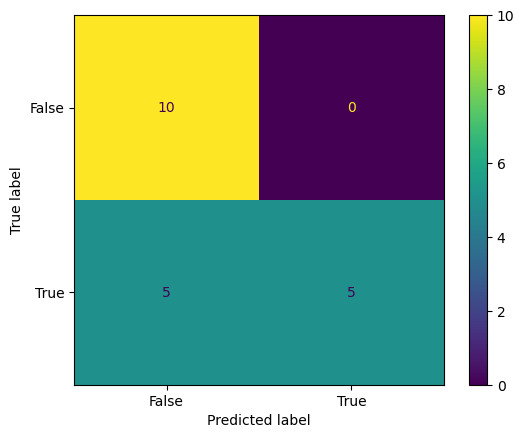

In [158]:
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm_openai, display_labels=[False, True])
cm_display.plot()

In [11]:
import nest_asyncio
nest_asyncio.apply()

from llama_index.core.evaluation import CorrectnessEvaluator

correctness_evaluator = CorrectnessEvaluator(llm=llm)
eval = []


for i, query in enumerate(X):
    response = index.as_query_engine(llm=llm).query(query).response
    print(response)
    eval_result = correctness_evaluator.evaluate(
        query=query,
        response=response,
        reference=ref_answers[i]
        )
    eval.append(eval_result)


0
What is the purpose of the HR manual at ABC & Associates?
The purpose of the HR manual at ABC & Associates is to guide staff regarding their rights and obligations. The manual sets out the guidelines that should be followed by all staff members, including the Senior Management Team and part-time staff, ensuring that they are aware of and adhere to the company's policies and procedures.
The purpose of the HR manual at ABC & Associates is to establish guidelines and policies related to various aspects of human resource management within the organization, including performance appraisal, compensation packages, overtime allowances, facilitation, discipline, termination of service, safety, and security.
1
How does ABC & Associates handle recruitment and selection of staff?
ABC & Associates handles recruitment and selection of staff through a clear and structured process as outlined in their HR manual: Recruitment Policy: The firm aims to recruit staff based on merit and open competition. 

In [17]:

records = []
for item in eval:
    records.append({'query' :item.query,
                    'score' : item.score,
                    'feedback' : item.feedback
                    })
print(pd.DataFrame.from_dict(records))

                                                query  score  \
0   What is the purpose of the HR manual at ABC & ...    3.5   
1   How does ABC & Associates handle recruitment a...    3.0   
2   What are the probationary terms for new employ...    2.0   
3   How does the firm conduct performance evaluati...    4.5   
4   What types of leave are available to employees...    4.5   
5   What are the disciplinary procedures in the ev...    3.0   
6   How are salary payments and deductions managed...    4.0   
7   What are the conditions for using the firm’s r...    3.0   
8   What does the induction process for new employ...    2.0   
9   How does the firm manage safety and security c...    NaN   
10  What is the average employee retention rate at...    4.0   
11  How does the firm handle conflicts of interest...    3.0   
12  What specific health benefits does the firm pr...    3.0   
13  How does the firm support employee mental heal...    4.0   
14  What are the company's sustainabilit